<a href="https://colab.research.google.com/github/LMAPcoder/Advanced-Computer-Vision/blob/main/ACV_sheet6_saliency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Computer Vision

## Exercise Sheet 6

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from matplotlib import pyplot as plt

### Task 1: Saliency Map in Python

Saliency maps are used to highlight the regions of an image that are most important to make a model's decision.

In [2]:
# Downloading picture from Google Drive
!wget --no-check-certificate --quiet 'https://docs.google.com/uc?export=download&id=1iRF0PsodSS-c0v-4ScVaMBCt3uVfNWkq' -O ouzel.png

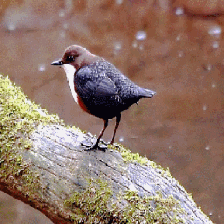

In [3]:
img_path = 'ouzel.png'
img = image.load_img(img_path, target_size=(224, 224)) #input image size in ImageNet dataset
img

In [4]:
# Downloading ResNet50 with ImageNet pretrained weights
model = ResNet50(weights='imagenet')

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0) # to add batch size dimmension
x = preprocess_input(x) #to adequate the input tensor to the model requirements

# Model prediction for the ouzel image
preds = model.predict(x)

print("Prediction shape:", preds.shape)

# decode the results into a list of tuples (class, description, probability)
print('Predicted:', decode_predictions(preds, top=3)[0])

1/1 [==============================] - 5s 5s/step
Prediction shape: (1, 1000)
35363/35363 [==============================] - 0s 0us/step
Predicted: [('n01601694', 'water_ouzel', 0.99614835), ('n01558993', 'robin', 0.0014834225), ('n01807496', 'partridge', 0.00022184158)]


Gradient of output with respect to the input

In [5]:
# Compute gradient of the output of a model <model> with respect to its input <inp>
# If the output of the model is a vector, <output_index> choses which element of output to use
def gradient_input(model, inp, output_index=0):
    inp_tensor = tf.convert_to_tensor(inp, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(inp_tensor) # enable gradient recording w.r.t. to this tensor
        output = tf.squeeze(model(inp_tensor)) # forward inference
        if output.ndim > 0:
            my_output = output[output_index] # pick right element from output
        else:
            my_output = output
    gradient = t.gradient(my_output, inp_tensor) # get gradient @my_output/@input
    gradient = np.squeeze(np.array(gradient)) # convert from tensor to numpy array
    return gradient

In [80]:
output_index = 20 #index of ouzel class within ImageNet

g = gradient_input(model, x, output_index)

print("Gradient shape:", g.shape)

Gradient shape: (224, 224, 3)


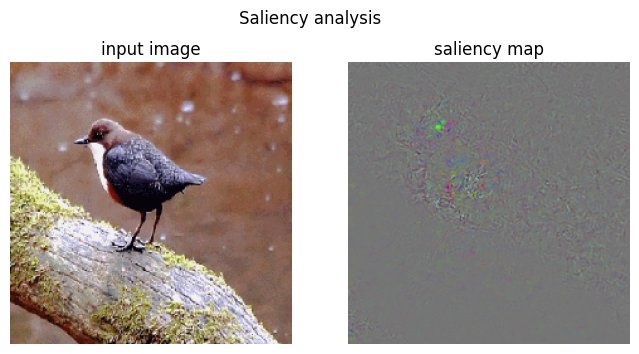

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

fig.suptitle(f'Saliency analysis')

axes[0].imshow(img)
axes[0].set_title('input image')
axes[0].axis('off')

axes[1].imshow(image.array_to_img(g))
axes[1].set_title('saliency map')
axes[1].axis('off')

plt.show()

In [81]:
M = abs(g).max(axis=-1)
M.shape

(224, 224)

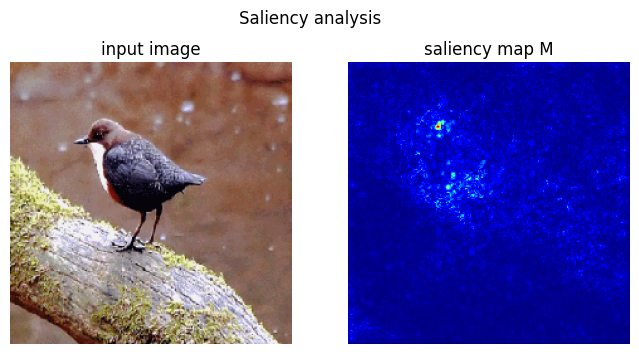

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

fig.suptitle(f'Saliency analysis')

axes[0].imshow(img)
axes[0].set_title('input image')
axes[0].axis('off')

axes[1].imshow(M, cmap='jet')
axes[1].set_title('saliency map M')
axes[1].axis('off')

plt.show()

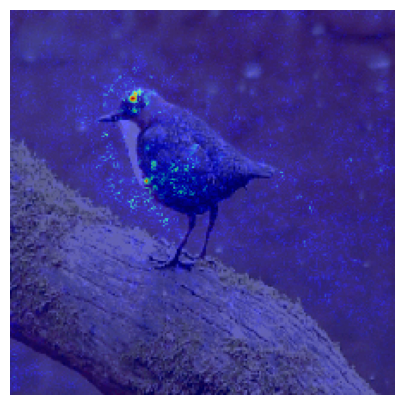

In [89]:
plt.figure(figsize=(5, 5))

# Display the original image
plt.imshow(img)

# Overlay the heatmap
plt.imshow(M, cmap='jet', alpha=0.6)

plt.axis('off')
plt.show()

### Task 2: Gradient of Node at Intermediate Layer With Respect to Input

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib.colors import LogNorm

In [ ]:
# Build a simple CNN with strided convolution layers
def define_model():
    inputs = tf.keras.Input(shape=(128,128,1),name='Inputs')
    x = layers.Conv2D(16,kernel_size=(5,5),activation='tanh',strides=1,name='L1')(inputs)
    x = layers.Conv2D(16,kernel_size=(5,5),activation='tanh',strides=2,name='L2')(x)
    x = layers.Conv2D(16,kernel_size=(3,3),activation='tanh',strides=1,name='L3')(x)
    x = layers.Conv2D(16,kernel_size=(3,3),activation='tanh',strides=2,name='L4')(x)
    x = layers.Conv2D(16,kernel_size=(3,3),activation='tanh',strides=1,name='L5')(x)
    x = layers.Conv2D(16,kernel_size=(3,3),activation='tanh',strides=2,name='L6')(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(10,activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# For an output node in <model> at the intermediate layer <layer_name>
# and spatial position <x>,<y> and channel index <c>, compute the gradient of
# that output node with respect to the input <inp>
def get_gradient(model,layer_name,x,y,c,inp):
    # model.get_layer(name=layer_name).output
    intermediate_layer_model = keras.Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

    output_index = np.index_exp[x,y,c]
    gradient = gradient_input(intermediate_layer_model, inp, output_index)
    return gradient


model = define_model()

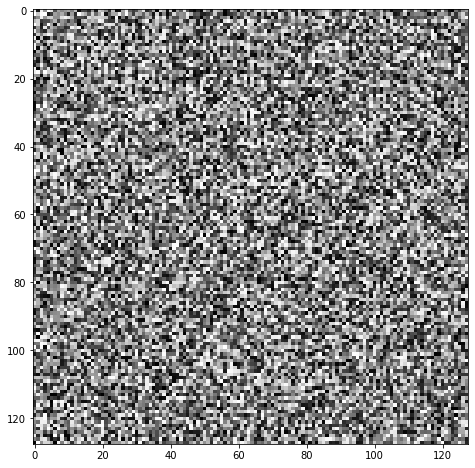

In [ ]:
# generate random input
inp = np.random.uniform(0,1,size=(1,128,128,1))
plt.figure(figsize = (8,8))
plt.imshow(np.squeeze(inp[0], axis=2), cmap='gray')
plt.show()

receptive field shape (33, 33)


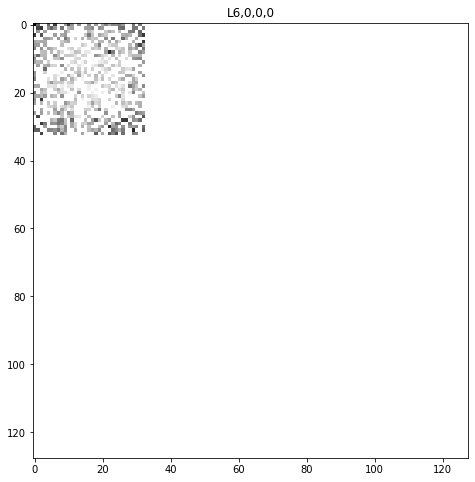

In [ ]:
# convert gradient to image and plot...
layer_name = 'L6'
x = 0
y = 0
c = 0

gradient = get_gradient(model, layer_name,x,y,c,inp)

#receptive field size
p = np.where(gradient != 0)
t = gradient[min(p[0]) : max(p[0]) + 1, min(p[1]) : max(p[1]) + 1]
print('receptive field shape',t.shape)

plt.figure(figsize = (8,8))
plt.imshow(gradient, cmap='gray', norm=LogNorm())
plt.title(f'{layer_name},{x},{y},{c}')
plt.show()

receptive field shape (17, 17)


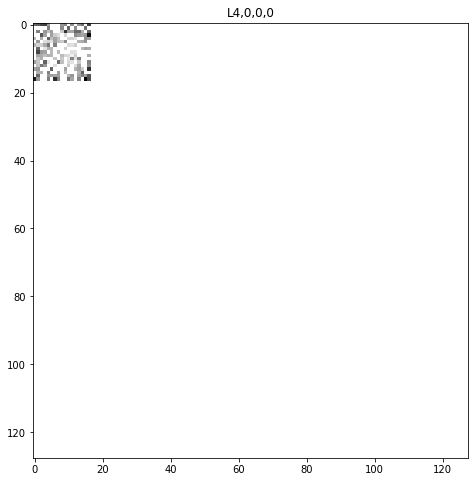

In [ ]:
layer_name = 'L4'
x = 0
y = 0
c = 0

gradient = get_gradient(model, layer_name,x,y,c,inp)

#receptive field size
p = np.where(gradient != 0)
t = gradient[min(p[0]) : max(p[0]) + 1, min(p[1]) : max(p[1]) + 1]
print('receptive field shape',t.shape)

plt.figure(figsize = (8,8))
plt.imshow(gradient, cmap='gray', norm=LogNorm())
plt.title(f'{layer_name},{x},{y},{c}')
plt.show()

receptive field shape (25, 25)


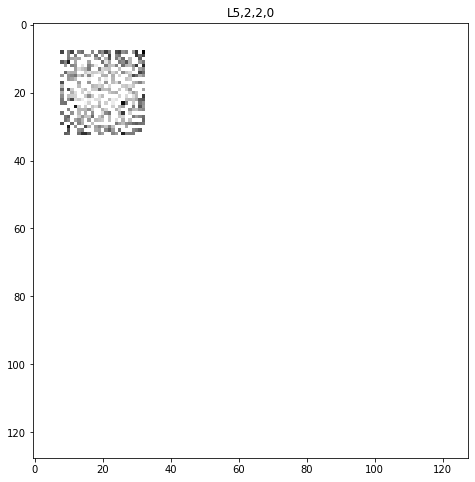

In [ ]:
layer_name = 'L5'
x = 2
y = 2
c = 0

gradient = get_gradient(model, layer_name,x,y,c,inp)

#receptive field size
p = np.where(gradient != 0)
t = gradient[min(p[0]) : max(p[0]) + 1, min(p[1]) : max(p[1]) + 1]
print('receptive field shape',t.shape)

plt.figure(figsize = (8,8))
plt.imshow(gradient, cmap='gray', norm=LogNorm())
plt.title(f'{layer_name},{x},{y},{c}')
plt.show()

receptive field shape (25, 25)


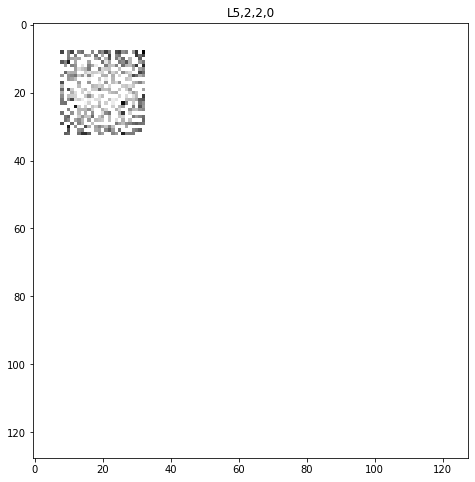

In [ ]:
layer_name = 'L5'
x = 2
y = 2
c = 0

gradient = get_gradient(model, layer_name,x,y,c,inp)

#receptive field size
p = np.where(gradient != 0)
t = gradient[min(p[0]) : max(p[0]) + 1, min(p[1]) : max(p[1]) + 1]
print('receptive field shape',t.shape)

plt.figure(figsize = (8,8))
plt.imshow(gradient, cmap='gray', norm=LogNorm())
plt.title(f'{layer_name},{x},{y},{c}')
plt.show()

### Task 3: Size of Receptive Fields in Convolutional Neural Networks

In [ ]:
x = 0
y = 0
c = 0

for _ in range(1,7):

  layer_name = f'L{_}'

  gradient = get_gradient(model, layer_name,x,y,c,inp)

  #receptive field size
  p = np.where(gradient != 0)
  t = gradient[min(p[0]) : max(p[0]) + 1, min(p[1]) : max(p[1]) + 1]
  print(f'receptive field shape for {layer_name}',t.shape)

receptive field shape for L1 (5, 5)
receptive field shape for L2 (9, 9)
receptive field shape for L3 (13, 13)
receptive field shape for L4 (17, 17)
receptive field shape for L5 (25, 25)
receptive field shape for L6 (33, 33)
